<a href="https://colab.research.google.com/github/lizzzb/Collaborative-Filtering-Algo-for-RecommenderSystems/blob/main/SurpriseSVD_for_CF_from_RecommendersGitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Surprise Singular Value Decomposition (SVD)


This notebook serves both as an introduction to the [Surprise](http://surpriselib.com/) library, and also introduces the 'SVD' algorithm which is very similar to ALS presented in the ALS deep dive notebook. This algorithm was heavily used during the Netflix Prize competition by the winning BellKor team.

Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

## 1 Matrix factorization algorithm

The SVD model algorithm is very similar to the ALS algorithm presented in the ALS deep dive notebook. The two differences between the two approaches are:

- SVD additionally models the user and item biases (also called baselines in the litterature) from users and items.
- The optimization technique in ALS is Alternating Least Squares (hence the name), while SVD uses stochastic gradient descent.

### 1.1 The SVD model

In ALS, the ratings are modeled as follows:

$$\hat r_{u,i} = q_{i}^{T}p_{u}$$

SVD introduces two new scalar variables: **the user biases $b_u$ and the item biases $b_i$.** The user biases are supposed to capture the tendency of some users to rate items higher (or lower) than the average. The same goes for items: some items are usually rated higher than some others. The model is SVD is then as follows:

$$\hat r_{u,i} = \mu + b_u + b_i + q_{i}^{T}p_{u}$$

**Where $\mu$ is the global average of all the ratings in the dataset.** The regularised optimization problem naturally becomes:

$$ \sum(r_{u,i} - (\mu + b_u + b_i + q_{i}^{T}p_{u}))^2 +     \lambda(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2)$$

where $\lambda$ is a the regularization parameter.


### 1.2 Stochastic Gradient Descent

The Stochastic Gradient Descent (SGD) method in this context is used to optimize the parameters in a recommendation model by iteratively adjusting them to reduce the error between the predicted and actual ratings.

Stochastic Gradient Descent (SGD) is a very common algorithm for optimization where the parameters (here the biases and the factor vectors) are **iteratively incremented with the negative gradients w.r.t the optimization function.** The algorithm essentially performs the following steps for a given number of iterations:


$$b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)$$
$$b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)$$  
$$p_u \leftarrow p_u + \gamma (e_{ui} \cdot q_i - \lambda p_u)$$
$$q_i \leftarrow q_i + \gamma (e_{ui} \cdot p_u - \lambda q_i)$$

where $\gamma$ is the learning rate and $e_{ui} =  r_{ui} - \hat r_{u,i} = r_{u,i} - (\mu + b_u + b_i + q_{i}^{T}p_{u})$ is the error made by the model for the pair $(u, i)$.

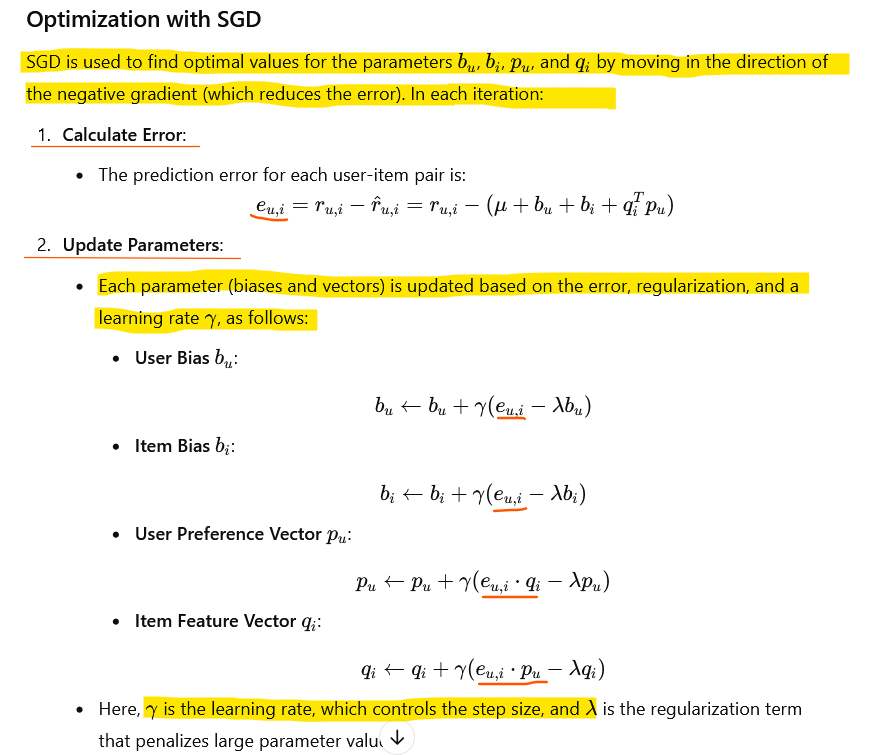

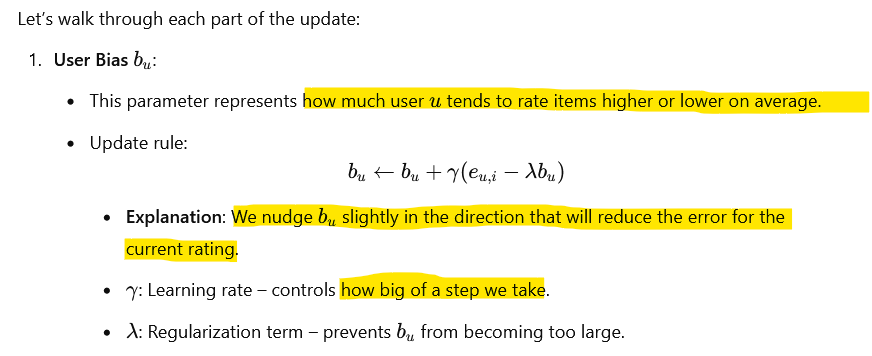



## 2 Surprise implementation of SVD

SVD is implemented in the [Surprise](https://surprise.readthedocs.io/en/stable/) library as a recommender module.
* Detailed documentations of the SVD module in Surprise can be found [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD).
* Source codes of the SVD implementation is available on the Surprise Github repository, which can be found [here](https://github.com/NicolasHug/Surprise/blob/master/surprise/prediction_algorithms/matrix_factorization.pyx).

The recommenders library might have a dependency on an older pandera version and is not picking up your updated installation. This is because, despite a global upgrade, sometimes the libraries inside the recommenders virtual environment may not be updated accordingly.

In [1]:
!pip uninstall -y recommenders
!pip install recommenders


!pip install pandera==0.7.1
!pip install surprise



Found existing installation: recommenders 1.2.0
Uninstalling recommenders-1.2.0:
  Successfully uninstalled recommenders-1.2.0
  Using cached recommenders-1.2.0-py3-none-any.whl.metadata (13 kB)
Using cached recommenders-1.2.0-py3-none-any.whl (356 kB)
  Using cached pandera-0.7.1-py3-none-any.whl.metadata (10 kB)
Using cached pandera-0.7.1-py3-none-any.whl (165 kB)
  Attempting uninstall: pandera
    Found existing installation: pandera 0.20.4
    Uninstalling pandera-0.20.4:
      Successfully uninstalled pandera-0.20.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
recommenders 1.2.0 requires pandera[strategies]>=0.15.0; python_version >= "3.9", but you have pandera 0.7.1 which is incompatible.


In [2]:
import sys
import surprise
import pandera

from pandera import SchemaModel
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import (
    rmse,
    mae,
    rsquared,
    exp_var,
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
    get_top_k_items,
)
from recommenders.models.surprise.surprise_utils import (
    predict,
    compute_ranking_predictions,
)
from recommenders.utils.notebook_utils import store_metadata


print(f"System version: {sys.version}")
print(f"Surprise version: {surprise.__version__}")
print(pandera.__version__)


System version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Surprise version: 1.1.4
0.7.1


In [3]:
# Top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = "100k"

### 3.1 Load data

In [4]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE, header=["userID", "itemID", "rating"]
)

data.head()

100%|██████████| 4.81k/4.81k [00:00<00:00, 21.0kKB/s]


,userID,itemID,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


### 3.2 Train the SVD Model

Note that Surprise has a lot of built-in support for [cross-validation](https://surprise.readthedocs.io/en/stable/getting_started.html#use-cross-validation-iterators) or also [grid search](https://surprise.readthedocs.io/en/stable/getting_started.html#tune-algorithm-parameters-with-gridsearchcv) inspired scikit-learn, but we will here use the provided tools instead.

We start by splitting our data into trainset and testset with the `python_random_split` function.

In [5]:
train, test = python_random_split(data, 0.75)

In the surprise library (a popular Python library for building and evaluating recommendation systems), the load_from_df method is used to create a Dataset object from a Pandas DataFrame. This Dataset object can then be used to train models with Surprise, by using the `build_full_trainset` method.

In [6]:
# 'reader' is being used to get rating scale (for MovieLens, the scale is [1, 5]).
# 'rating_scale' parameter can be used instead for the later version of surprise lib:
# https://github.com/NicolasHug/Surprise/blob/master/surprise/dataset.py
train_set = surprise.Dataset.load_from_df(
    train, reader=surprise.Reader("ml-100k")
).build_full_trainset()
train_set

In newer versions of the surprise library, it's often better to specify the rating_scale parameter directly instead of using "ml-100k". This makes the code more flexible and explicit about the rating scale.

In [7]:
from surprise import Dataset, Reader

# Define the rating scale explicitly as [1, 5]
reader = Reader(rating_scale=(1, 5))

# Create Dataset from DataFrame
train_set = Dataset.load_from_df(train, reader=reader).build_full_trainset()

**Why Use `build_full_trainset`?**

The `build_full_trainset` method is used to include all samples in the dataset for training. This is useful when you want to train your model on the entire dataset rather than leaving out any part of it for validation or testing.

If you need to split the data for training and testing, you can use train_test_split or cross-validation tools provided by surprise instead of `build_full_trainset`.

----
The [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) has a lot of parameters. The most important ones are:
- `n_factors`, which controls **the dimension of the latent space** (i.e. the size of the vectors $p_u$ and $q_i$). Usually, the quality of the training set predictions grows with as `n_factors` gets higher.
- `n_epochs`, which defines **the number of iteration of the SGD procedure.**

Note that both parameter also affect the training time.


We will here set `n_factors` to `200` and `n_epochs` to `30`. To train the model, we simply need to call the `fit()` method.

In [8]:
svd = surprise.SVD(random_state=0, n_factors=200, n_epochs=30, verbose = True)

with Timer() as train_time:
  svd.fit(train_set)

print(f"Took {train_time.interval} seconds for training")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Took 2.905089295000039 seconds for training


- `surprise.SVD`:
  This creates an instance of the SVD model, which is commonly used for collaborative filtering in recommendation systems. SVD decomposes the user-item interaction matrix into latent factors for users and items, making it useful for making predictions on user preferences.

- Parameters:
   - `random_state=0`: Sets a seed for random number generation, which ensures the results are reproducible. Either none (different) or integer (same).
   - `n_factors=200`: Specifies the number of latent factors. This controls the dimensionality of the user and item embeddings. A higher value typically allows for a more nuanced model, but it can also lead to overfitting if too large.
   - n_epochs=30: Specifies the number of iterations over the entire dataset during training. More epochs allow the model to learn better, but too many epochs can cause overfitting.
   - `verbose=True`: Enables verbose output, which means the model will print training progress for each epoch. This is useful to monitor convergence.

- `svd.fit(train_set)`:
  This command trains the SVD model on the train_set. It iteratively updates the model parameters over n_epochs epochs to minimize prediction error.

- `with Timer() as train_time`:
  The `Timer()` context manager is being used to measure how long the training takes.
- `train_time.interval` will give the elapsed time for the training process in seconds.

### 3.3 Prediction

Now that our model is fitted, we can call `predict` to get some predictions. `predict` returns an internal object `Prediction` which can be easily converted back to a dataframe:

In [9]:
predictions = predict(svd, test, usercol="userID", itemcol="itemID")
predictions.head(30)

,userID,itemID,prediction
0,877,381,3.698217
1,815,602,3.590957
2,94,431,3.841149
3,416,875,2.642248
4,500,182,4.384139
5,259,1074,2.981694
6,598,286,3.685148
7,886,496,3.127939
8,837,15,3.060775
9,521,184,3.591126


In [10]:
sorted_predictions = predictions.sort_values(by=['userID', 'prediction'], ascending=[True, False])
sorted_predictions.head(30)

,userID,itemID,prediction
24930,1,10,4.679460
22829,1,168,4.670494
591,1,238,4.648031
12147,1,8,4.409130
1343,1,181,4.402904
15894,1,64,4.348149
15647,1,262,4.322677
22956,1,151,4.201548
15370,1,256,4.191618
656,1,100,4.167208


### 3.4 Remove rated movies in the top k recommendations

To compute ranking metrics, we need predictions on all user-item pairs. We remove though the items already watched by the user, since we choose not to recommend them again.

This code section is designed to generate predictions for all user-item pairs and measure the time it takes to do so. It also focuses on ranking predictions and removes items already seen by the user to avoid recommending them again.

In [11]:
with Timer() as test_time:
  all_predictions = compute_ranking_predictions(svd, train,usercol="userID", itemcol="itemID", remove_seen=True
    )
print(f"Took {test_time.interval} seconds for prediction.")

Took 23.539370308000002 seconds for prediction.


In [12]:
all_predictions.head(30)

,userID,itemID,prediction
0,1,1,3.974220
3,1,4,4.134061
5,1,6,3.652207
7,1,8,4.409130
9,1,10,4.679460
19,1,20,3.775700
20,1,21,3.323430
25,1,26,3.550249
29,1,30,4.092564
30,1,31,3.345538


In [13]:
all_sorted_predictions = sorted_predictions.sort_values(by=['userID', 'prediction'], ascending=[True, False])
all_sorted_predictions.head(30)

,userID,itemID,prediction
24930,1,10,4.679460
22829,1,168,4.670494
591,1,238,4.648031
12147,1,8,4.409130
1343,1,181,4.402904
15894,1,64,4.348149
15647,1,262,4.322677
22956,1,151,4.201548
15370,1,256,4.191618
656,1,100,4.167208


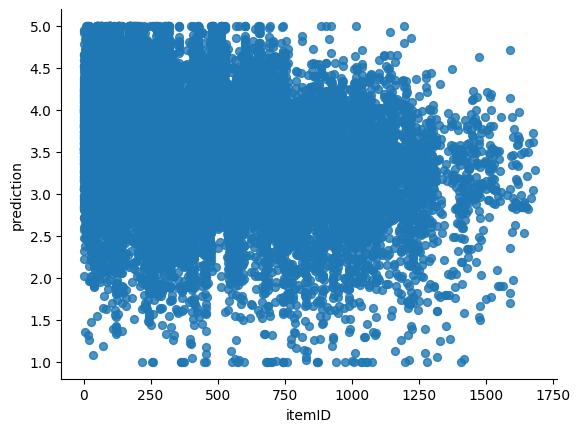

In [15]:
# @title itemID vs prediction

from matplotlib import pyplot as plt
all_sorted_predictions.plot(kind='scatter', x='itemID', y='prediction', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

The model generates predictions uniformly across items, irrespective of item popularity. Even though there are more interactions with popular items (lower itemIDs), the model may be generating similar prediction scores across both popular and niche items.

The visualization in the scatter plot doesn't represent interaction frequency. Each point represents a prediction for an item, but it doesn’t reflect the number of times that prediction occurs. In other words, some points represent multiple interactions, which isn’t immediately clear in the scatter plot.

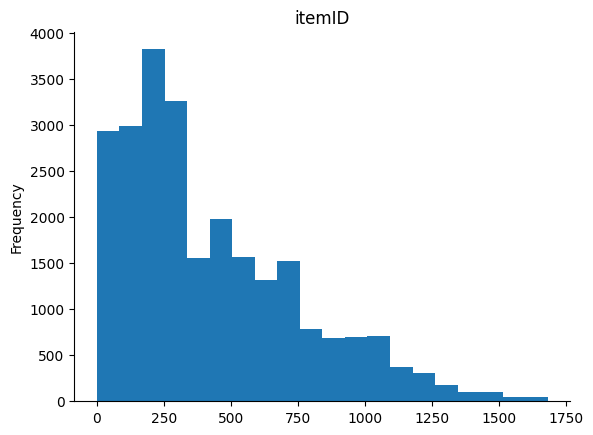

In [14]:
# @title itemID

from matplotlib import pyplot as plt
all_sorted_predictions['itemID'].plot(kind='hist', bins=20, title='itemID')
plt.gca().spines[['top', 'right',]].set_visible(False)

- Left side: A few items have very high frequencies, indicating that these items are popular or commonly interacted with. For example, the first bar peaks around 3500–4000, meaning these items have around 3500–4000 interactions each.
- Right side: The frequency drops off as the item IDs increase, meaning that many items are less frequently interacted with. Beyond item ID 500, the frequencies become more sparse, indicating these items are less popular.
- Long Tail: The histogram suggests a "long tail" distribution, a common pattern in recommendation systems where a small number of popular items receive most of the interactions, while the majority of items have relatively few interactions.

### 3.5 Evaluate how well SVD performs

**The SVD algorithm was specifically designed to predict ratings as close as possible to their actual values.** In particular, it is designed to have a very low RMSE (Root Mean Squared Error), computed as:

$$\sqrt{\frac{1}{N} \sum(\hat{r_{ui}} - r_{ui})^2}$$

As we can see, the RMSE and MAE (Mean Absolute Error) are pretty low (i.e. good), indicating that on average the error in the predicted ratings is less than 1. The RMSE is of course a bit higher, because high errors are penalized much more.

For comparison with other models, we also display **Top-k and ranking metrics (MAP, NDCG, etc.)**.

**! Note however that the SVD algorithm was designed for achieving high accuracy, not for top-rank predictions. !**

In [16]:
eval_rmse = rmse(test, predictions)         # The average difference between predicted and actual ratings. Lower values are better.
eval_mae = mae(test, predictions)           # Similar to RMSE, but less sensitive to outliers. Lower values are better.
eval_rsquared = rsquared(test, predictions) # How well the model fits the data. Higher values indicate a better fit.
eval_exp_var = exp_var(test, predictions)   # Similar to R-squared, but focuses on the proportion of variance in the data that is explained by the model. Higher values indicate a better fit.

eval_map = map_at_k(test, all_predictions, col_prediction="prediction", k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction="prediction", k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction="prediction", k=TOP_K
)
eval_recall = recall_at_k(test, all_predictions, col_prediction="prediction", k=TOP_K)

print(
    "RMSE:\t\t%f" % eval_rmse,
    "MAE:\t\t%f" % eval_mae,
    "rsquared:\t%f" % eval_rsquared,
    "exp var:\t%f" % eval_exp_var,
    sep="\n",
)

print("----")

print(
    "MAP:\t\t%f" % eval_map,
    "NDCG:\t\t%f" % eval_ndcg,
    "Precision@K:\t%f" % eval_precision,
    "Recall@K:\t%f" % eval_recall,
    sep="\n",
)

/usr/local/lib/python3.10/dist-packages/recommenders/evaluation/python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
/usr/local/lib/python3.10/dist-packages/recommenders/evaluation/python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


RMSE:		0.948771
MAE:		0.747003
rsquared:	0.288045
exp var:	0.288157
----
MAP:		0.051213
NDCG:		0.109878
Precision@K:	0.100318
Recall@K:	0.035359


**Mean Average Precision (MAP)**

MAP measures **the average precision across all users in the dataset**. It **considers the order of recommendations and focuses on relevant items**.

$MAP = (1/N) * Σ (AveragePrecision(u))$ for all users $u$

Where:
   - $N$ is the total number of users.
   - $AveragePrecision(u)$ is the average precision for user u.
   - Average Precision is calculated by **averaging precision values at different recall levels for each user.**

Relevance: MAP is a good overall performance metric for recommender systems as it focuses on relevant recommendations and considers their ranking.

----

**Normalized Discounted Cumulative Gain (NDCG)**

NDCG evaluates **the ranking quality of recommendations by considering the relevance of items and their positions in the list.** It penalizes highly relevant items placed lower in the ranking.

$NDCG@k = DCG@k / IDCG@k$

 Where:
 - $DCG@k$ (Discounted Cumulative Gain) is the sum of the graded relevance of the top k recommendations, discounted by their position.
 - $IDCG@k$ (Ideal Discounted Cumulative Gain) is the DCG for the ideal ranking of the top k items.

Relevance: NDCG is useful when the order of recommendations is important, such as in search result ranking. It is more sensitive to the position of highly relevant items compared to MAP.

----

**Precision@k**

Precision@k measures **the proportion of relevant items among the top k recommendations for a user.**

$Precision@k = (Number Of Relevant Items in Top k) / k$

Relevance: Precision@k is useful when you want to focus on **the accuracy of the top recommendations.** It is often used when users are only interested in the first few recommendations.

----

**Recall@k**

Recall@k measures **the proportion of relevant items that are retrieved in the top k recommendations compared to all relevant items** for a user.

$Recall@k = (Number Of Relevant Items In Top k) / (Total Number Of Relevant Items For The User)$

Relevance: Recall@k is useful when you want to ensure that **a significant portion of the relevant items is being recommended**, even if it means including some irrelevant items.


In summary:
- MAP and NDCG are good for evaluating the overall ranking quality of recommendations, considering both relevance and position.
- Precision@k focuses on the accuracy of the top recommendations.
- Recall@k focuses on retrieving a large fraction of the relevant items.
